In [1]:
import numpy as np
import sys
from os.path import join
from os import remove
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
# import pyntcloud # http://pyntcloud.readthedocs.io/en/latest/
DATA_DIR = '../../Stanford3dDataset_v1.2'
%matplotlib notebook

In [2]:
# copied from utils.py, normalizes pointclouds
def normalize_pointclouds_stanford(pointcloud_arr):
  """
  Shifts pointclouds so the smallest xyz values map to the origin. We want to
  preserve relative scale, but this also leads to excess or missed computation
  between rooms.

  TODO: allow layers to input a dynamic dimension (requires changes number of
  steps as well)

  Args:
    pointcloud_arr (np.ndarray): array of all pointclouds with shape
                                 (clouds, points, 6)
  """
  # Find the minimum x, y, and z values.
  shifted_pointclouds = []
  gmax = None

  # Loop through scenes.
  for pointcloud in pointcloud_arr:
    xyz = pointcloud[:, :3]
    mins = xyz.min(axis=0)
    maxes = xyz.max(axis=0)
    dims = maxes-mins
    if gmax is None:
      gmax = maxes
    else:
      gmax = np.array([dims, gmax]).max(axis=0)

    shifted_pointclouds.append(np.array(xyz-mins))
  return shifted_pointclouds, gmax

In [9]:
# load and normalize train rooms
print('loading data points')
rooms = np.load(join(DATA_DIR, 'intermediates/trn_data.npy')) # load sample data
print('loaded', len(rooms), 'point clouds')
print('normalizing rooms')
rooms, gmax = normalize_pointclouds_stanford(rooms)
print('normalized rooms')
rooms = np.array(rooms)

loading data points
loaded 224 point clouds
normalizing rooms
normalized rooms


In [4]:
# load training bboxes
print('loading bboxes')
bboxes = np.load(join(DATA_DIR, 'outputs/bbox_trn_labels.npy'))
print('loaded', len(bboxes), 'rooms\' bboxes')

loading bboxes
loaded 224 rooms' bboxes


In [47]:
bboxes.shape

(224,)

In [41]:
# plotting bboxes
start = time.time()
idx = 50 # room number to plot
r = np.copy(rooms[idx])

# remove boundaries of room so we can see inside
min_x = np.min(r[:, 0])
min_y = np.min(r[:, 1])
min_z = np.min(r[:, 2])
max_x = np.max(r[:, 0])
max_y = np.max(r[:, 1])
max_z = np.max(r[:, 2])
end_padding = 0.1
r = np.array([q for q in r if q[0] - end_padding > min_x ])
r = np.array([q for q in r if q[1] - end_padding > min_y ])
r = np.array([q for q in r if q[2] - end_padding > min_z ])
r = np.array([q for q in r if q[0] + end_padding < max_x ])
r = np.array([q for q in r if q[1] + end_padding < max_y ])
r = np.array([q for q in r if q[2] + end_padding < max_z ])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        
# for each bbox, plot the 12 lines that correspond to the boundary of the box
for bbox in bboxes[idx]:
    for i in range(3):
        for j in range(2):
            for k in range(2): 
                tups = np.zeros((3, 2))
                tups[i] = (bbox[i], bbox[i+3])
                tups[(i+1)%3] = (bbox[(i + 1)%3 + 3*k], bbox[(i + 1)%3 + 3*k])
                tups[(i+2)%3] = (bbox[(i+2)%3 + 3*j], bbox[(i+2)%3 + 3*j])
                ax.plot3D(tups[0], tups[1], tups[2], color='r')

# skip 1-(1/skip_factor) fraction of pts
skip_factor = 2
# plot the actual points of the room
ax.scatter(r[::skip_factor, 0], r[::skip_factor, 1], r[::skip_factor, 2], s = 1, color='b')
plt.show()
# print('Plotting {} points takes {} seconds.'.format(int(r.shape[0]//skip_factor), time.time()-start))

<IPython.core.display.Javascript object>

In [13]:
# from object_boundaries.py
def generate_bbox_points(pcl, bboxes):
    '''
        Given a pointcloud and a set of bounding boxes, returns an array of an  array of points that appear in the bbox

        Args: pcl: N x 6 ndarray, where N is number of pts in pointcloud
               bboxes: M x 6 ndarray representing M bboxes
        Returns:
              M x X x 6 array,  X can be of varying size
    '''
    return np.array([pts_single_bbox(pcl, bbox) for bbox in bboxes])


def pts_single_bbox(pcl, bbox):
    '''
        Generates points residing in coordinates defined by bbox in pointcloud

        Args: pcl: N x 6 ndarray, where N is number of points in pointcloud
               bbox: 6-dim array, [min_x, min_y, min_z, max_x, max_y, max_z]
        Returns: X x 6 ndarray, where X is number of points within bbox for the particular pointcloud
    '''
    indices = np.where((pcl[:, 0] >= bbox[0]) &  (pcl[:, 0] <= bbox[3]) & (pcl[:, 1] >= bbox[1]) & (pcl[:, 1] <= bbox[4]) & (pcl[:, 2] >= bbox[2]) & (pcl[:, 2] <= bbox[5]))
#     indices = np.where((pcl[:, 0] >= bbox[0]))
    return pcl[indices]


def create_bounds(data):
    x_vals = data[:, 0]
    max_x = max(x_vals)
    min_x = min(x_vals)
    y_vals = data[:, 1]
    max_y = max(y_vals)
    min_y = min(y_vals)
    z_vals = data[:, 2]
    max_z = max(z_vals)
    min_z = min(z_vals)

    return [min_x, min_y, min_z, max_x, max_y, max_z]

In [35]:
# choose some random label bbox
single_bbox = bboxes[50][13]
print(single_bbox)

[ 3.72800016  0.03700018  0.98499995  6.24300003  0.0800004   2.31399989]


In [36]:
# take points inside that bbox
cand_pts = pts_single_bbox(rooms[50], single_bbox)
print(cand_pts.shape)

(33599, 3)


<IPython.core.display.Javascript object>


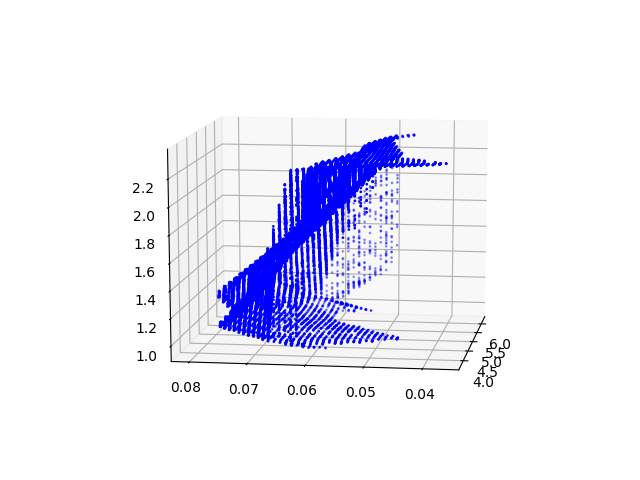

Plotting 33599 points takes 0.9383695125579834 seconds.


In [37]:
# plot the points inside this bbox
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
start = time.time()
skip_factor = 1
ax.scatter(cand_pts[::skip_factor, 0], cand_pts[::skip_factor, 1], cand_pts[::skip_factor, 2], s = 1, color='b')
plt.show()
print('Plotting {} points takes {} seconds.'.format(int(cand_pts.shape[0]//skip_factor), time.time()-start))

As you can see, this maintains the shape decently well and just includes a few extraneous points. Let's try this for more examples.

chair_5.txt
2132 points added


<IPython.core.display.Javascript object>


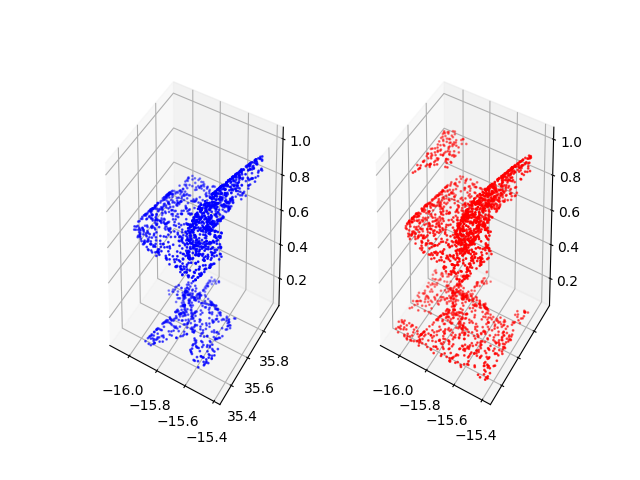

window_1.txt
1518 points added


<IPython.core.display.Javascript object>


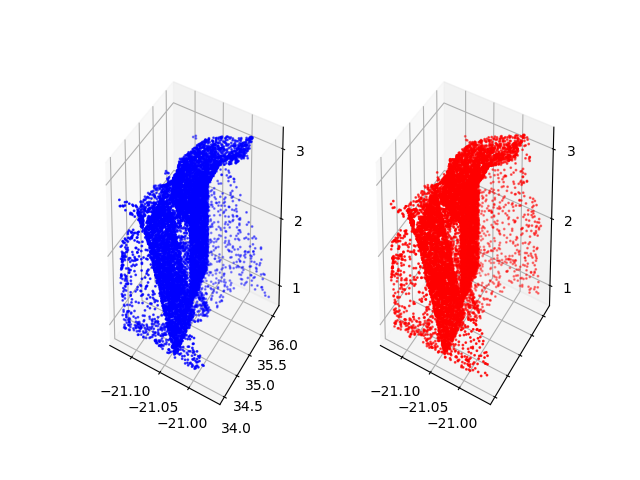

door_1.txt
11751 points added


<IPython.core.display.Javascript object>


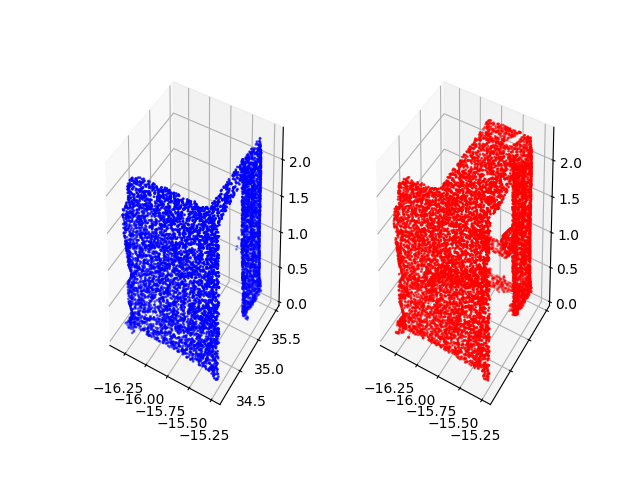

table_2.txt
3977 points added


<IPython.core.display.Javascript object>


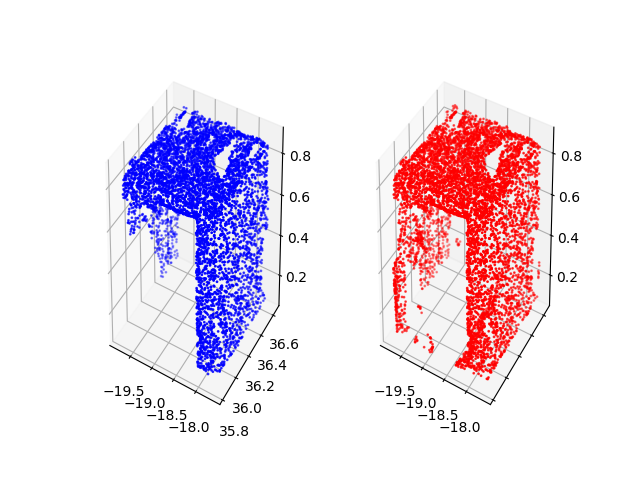

clutter_5.txt
356 points added


<IPython.core.display.Javascript object>


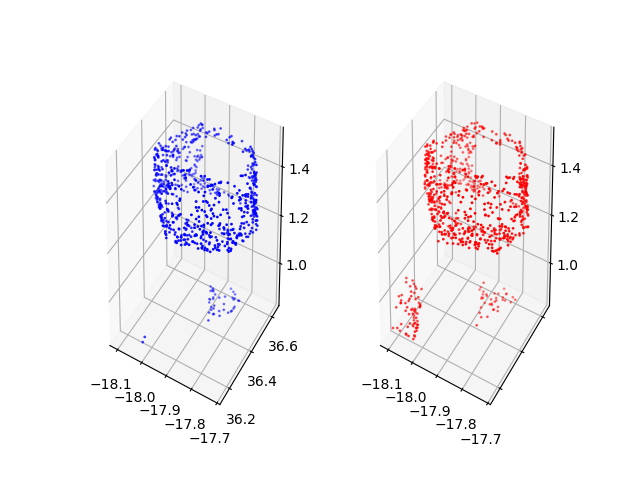

clutter_7.txt
338 points added


<IPython.core.display.Javascript object>


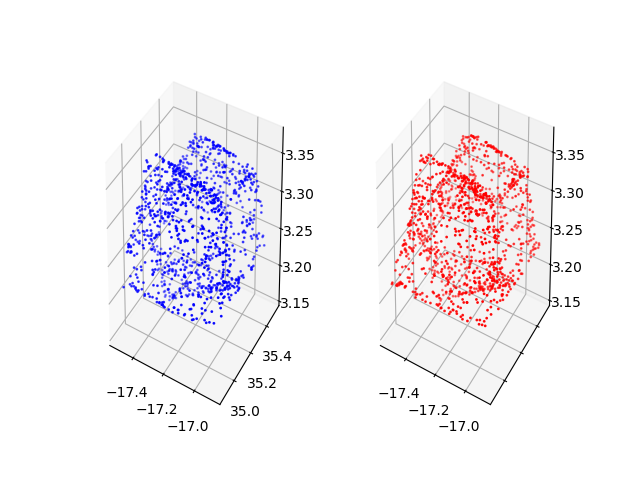

clutter_2.txt
12 points added


<IPython.core.display.Javascript object>


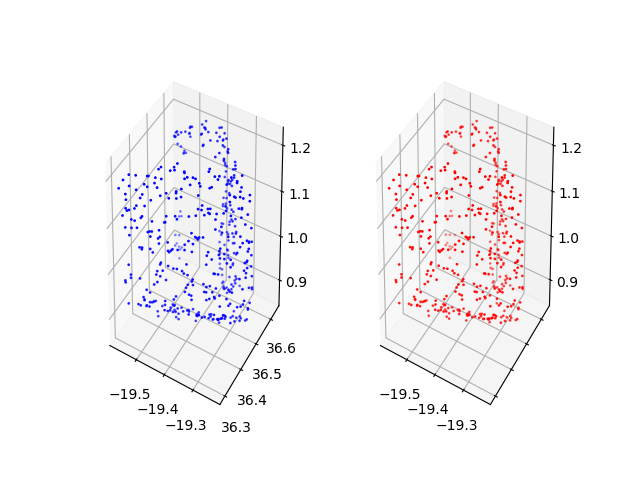

chair_1.txt
1178 points added


<IPython.core.display.Javascript object>


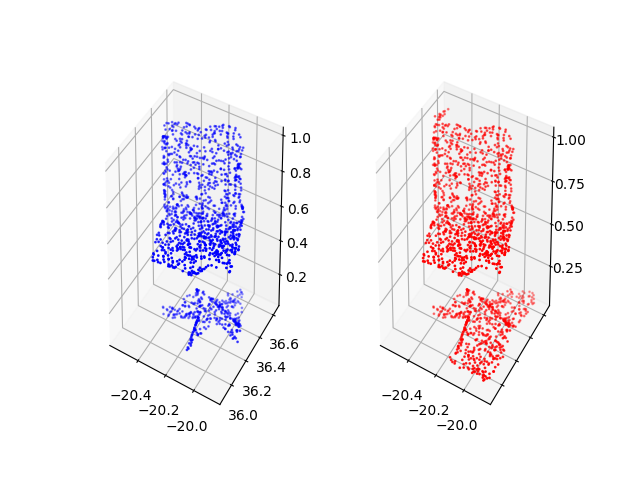

beam_1.txt
659 points added


<IPython.core.display.Javascript object>


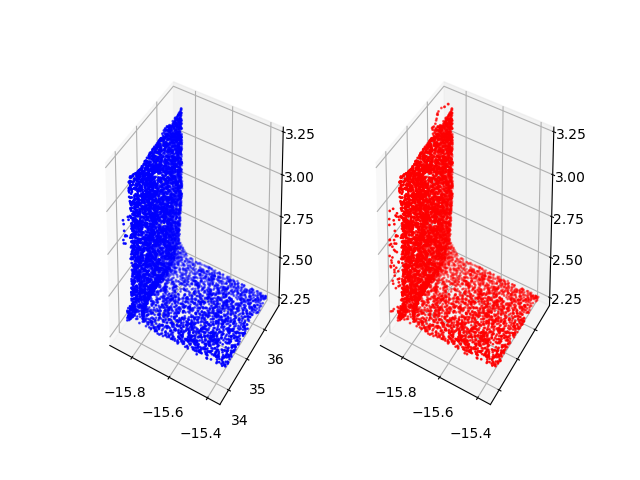

clutter_8.txt
297 points added


<IPython.core.display.Javascript object>


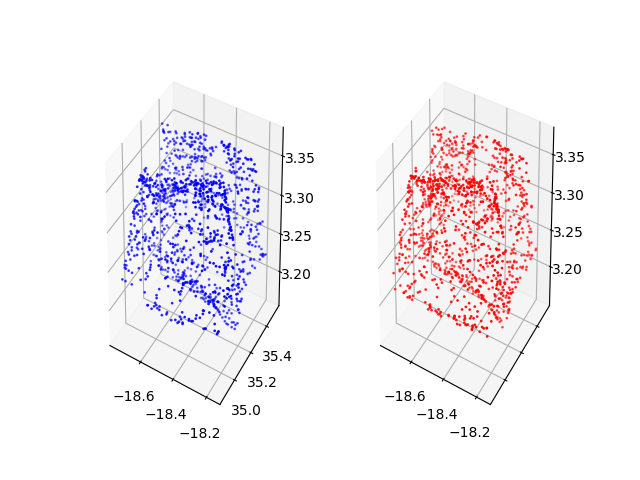

clutter_6.txt
3170 points added


<IPython.core.display.Javascript object>


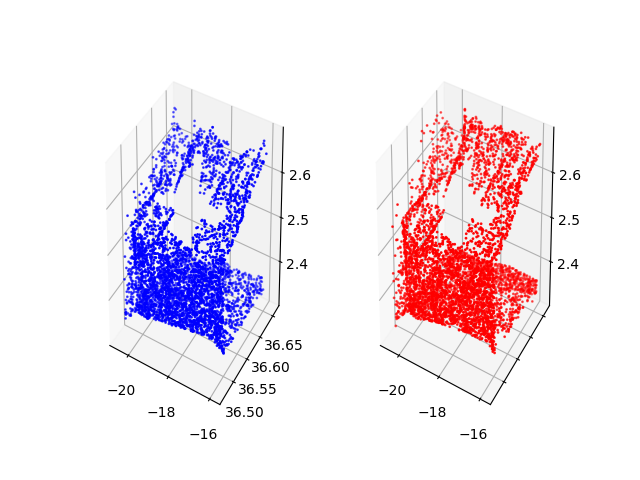

clutter_4.txt
29 points added


<IPython.core.display.Javascript object>


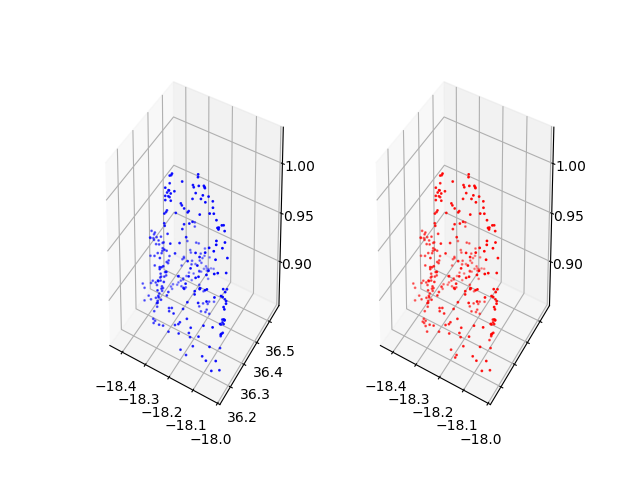

clutter_3.txt
1 points added


<IPython.core.display.Javascript object>


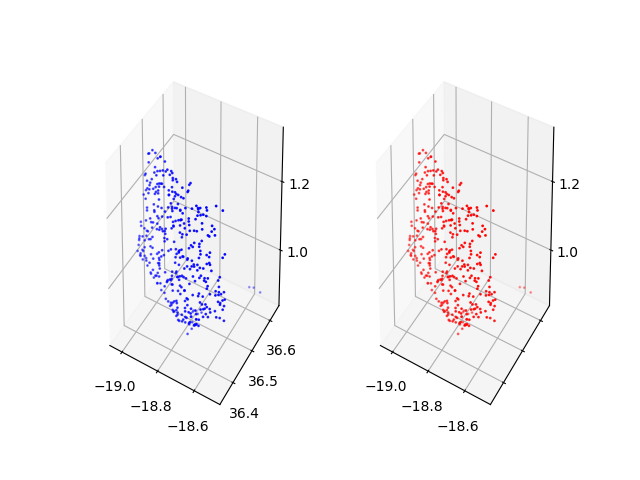

chair_2.txt
1177 points added


<IPython.core.display.Javascript object>


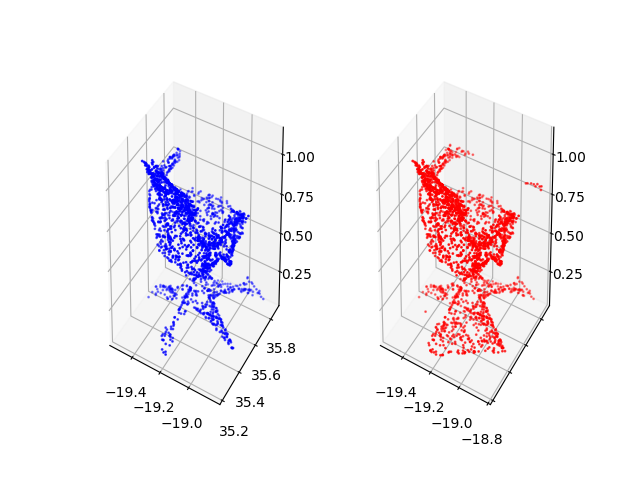

clutter_1.txt
489 points added


<IPython.core.display.Javascript object>


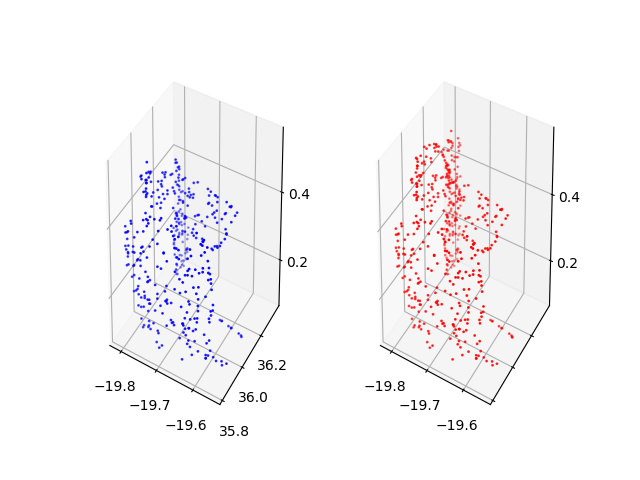

board_1.txt
1417 points added


<IPython.core.display.Javascript object>


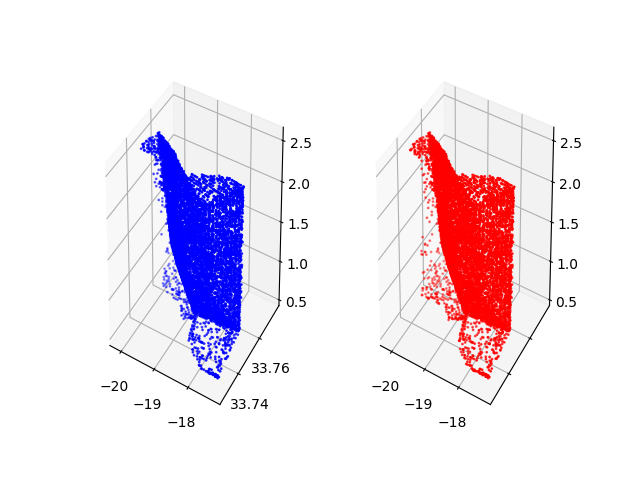

chair_3.txt
2149 points added


<IPython.core.display.Javascript object>


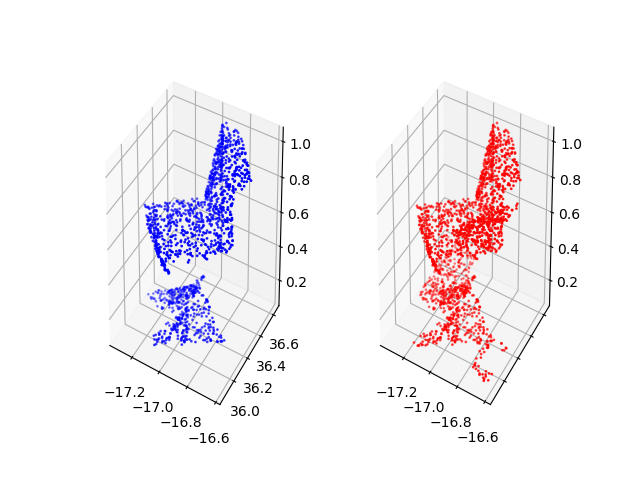

clutter_9.txt
301 points added


/home/sahinera/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


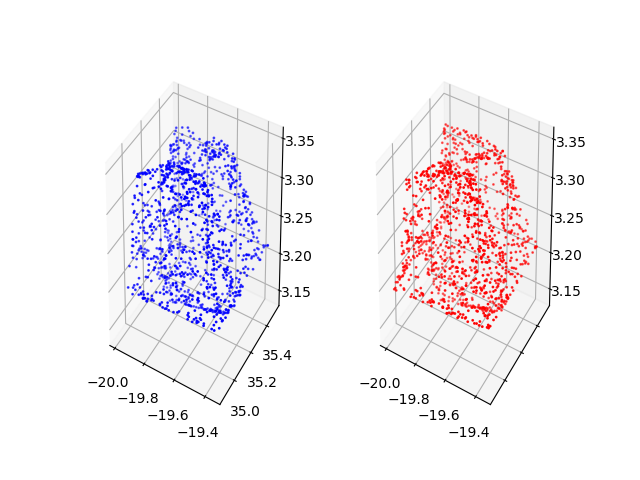

table_1.txt
7816 points added


<IPython.core.display.Javascript object>


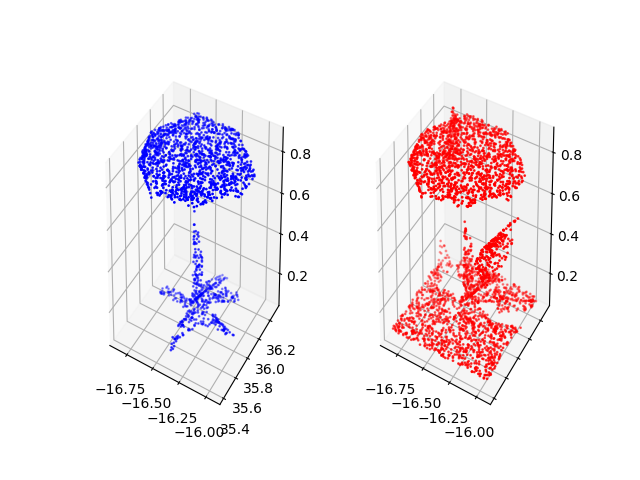

bookcase_1.txt
0 points added


<IPython.core.display.Javascript object>


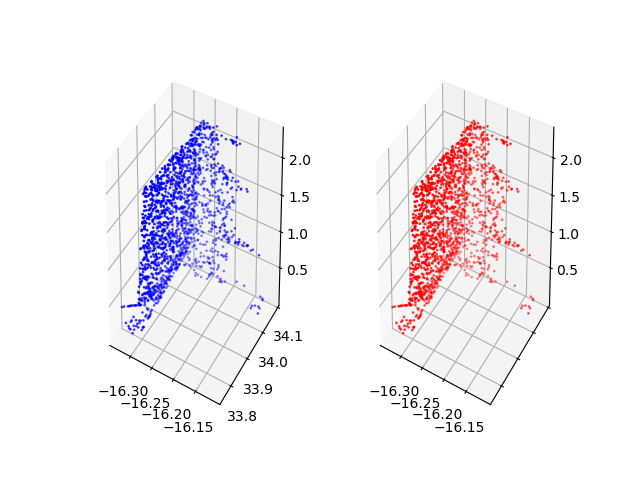

column_1.txt
2095 points added


<IPython.core.display.Javascript object>


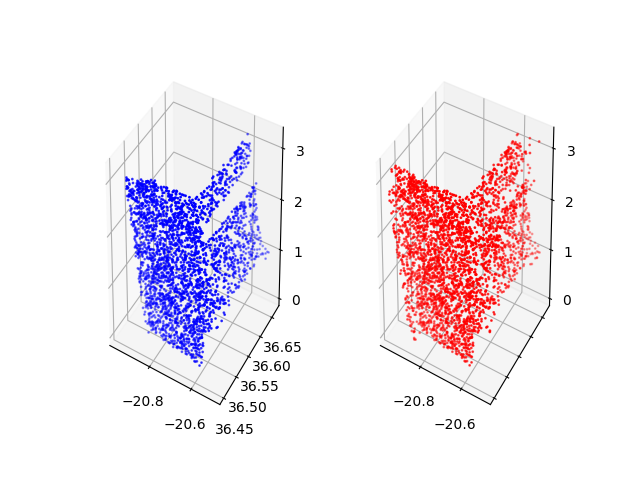

chair_4.txt
284 points added


<IPython.core.display.Javascript object>


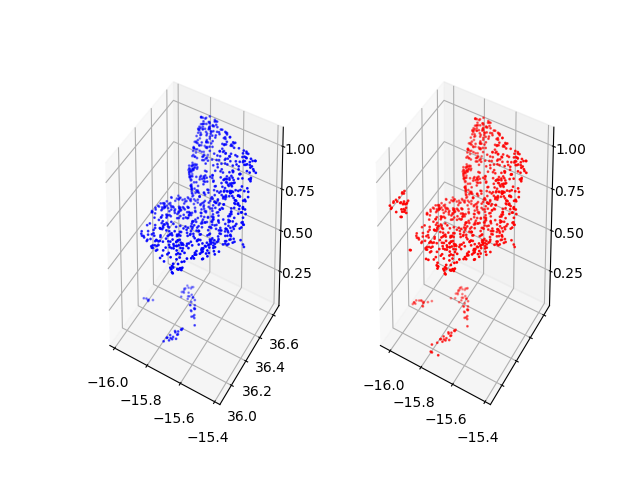

In [20]:
import os
for f in os.listdir(join(DATA_DIR, 'Annotations/')):
    if 'wall' in f or 'floor' in f or 'ceiling' in f:
        continue
    
    print(f)
    shape = np.genfromtxt(join(DATA_DIR, 'Annotations', f))
    bbox = create_bounds(shape)
    cand_pts = pts_single_bbox(xyzrgb_full, bbox)
    print(len(cand_pts) - len(shape), 'points added')
    fig, (ax, ax2) =  plt.subplots(1, 2, sharey=True, subplot_kw=dict(projection='3d'))
    skip_factor = 5
    ax.scatter(shape[::skip_factor, 0], shape[::skip_factor, 1], shape[::skip_factor, 2], s = 1, color='b')
    ax2.scatter(cand_pts[::skip_factor, 0], cand_pts[::skip_factor, 1], cand_pts[::skip_factor, 2], s = 1, color='r')
    plt.show()


As we can see, there are definitely points being added but the general shapes of objects are being retained--shouldn't heavily impact classification ability.